<a href="https://colab.research.google.com/github/sambethune/causal_learning/blob/master/01_5_%3E08_5_nb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MIMIC-3 Analysis

Let's examine an example subset of the MIMIC-3 database to see if we can infer any causal relations.

## Configuration and Cleaning

In [0]:
from google.colab import drive, files
drive.mount('/content/drive')

In [0]:
% cd /content/drive/My Drive/SCIE3250 Journal/01 5 -> 08 5

In [0]:
! pip install --upgrade pandas==0.24.0  # We require this version of pandas
! pip install causalnex
! pip install ipdb
import ipdb

In [0]:
files.upload()

In [3]:
import pandas as pd
df = pd.read_csv('mimic_day_blocks_ARDS2.csv', delimiter=',')
df.head()

,HADM_ID,CHARTDATE,BMI,RSC,PaO2/FiO2,PaCO2,Tidal_ml,Plateau_Pressure_cmH2O,Total_PEEP_cmH2O,PaO2,FiO2,ARDS,AGE,GENDER,AGE_INTERVALS,HCO3,Creatinine
0,100024,2170-09-19,29.52852,42.38806,2.28000,45.0,568.0,19.0,5.6,114.0,50.0,0,71,M,"(70, 75]",24.0,0.8
1,100035,2115-02-22,31.63272,25.00000,1.40000,97.0,500.0,30.0,10.0,84.0,60.0,1,37,M,"(35, 40]",33.0,1.2
2,100035,2115-02-23,31.63272,37.42857,0.93333,35.0,524.0,30.0,16.0,56.0,60.0,1,37,M,"(35, 40]",24.0,1.0
3,100035,2115-02-24,31.63272,50.72727,1.06154,54.0,558.0,24.0,13.0,69.0,65.0,1,37,M,"(35, 40]",30.0,0.8
4,100035,2115-02-25,31.63272,40.10000,2.10000,59.0,401.0,30.0,20.0,84.0,40.0,1,37,M,"(35, 40]",30.0,1.6


A quick rundown of our dataframe:
- HADM_ID -> Some sort of patient admission ID.
- CHARTDATE -> Corresponding timestamp.
- BMI -> Body Mass Index; Underweight[<18.5], Healthy[18.5-24.9], Overweigh[25-29.9], Obese[>30].
- RSC -> ?
- PaO2/FiO2 -> Divisor PaO2 & FiO2; Normal[>200], Moderate[100-200], Severe[<100].
- PaCO2 -> Partial CO2 pressure, can indicate respiratory issues. Low[<75], Healthy[75-100], High[>100]
- Tidal_ml -> Air intake per cycle; usually recorded with body mass in ml/kg. Less for existing conditions etc.
- Plateau_Pressure_cmH2O -> Alveolar pressure; Healthy[<30], Risk[>30]
- Total_PEEP_cmH2O -> Put into ~5 bins.
- PaO2 -> Partial O2 pressure; Low[<80], Healthy [80-100], High[>100].
- Fraction of inspired O2 -> Oxygen enriched air, content; Guess that Normal[>30], High[>30].
- ARDS -> ARDS Binary; Yes[1], No[0].
- HCO3 -> Bicarbonate dosage, measures acid imbalance; ~4 bins.
- Creatinine -> Measures kidney health; Low[0.6], Healthy[0.6-1.2], High[>1.2].


We refine our parameters.

In [0]:
drops = ['HADM_ID', 'CHARTDATE']
df = df.drop(columns=drops)

Also we digitalise our discrete variables.

In [5]:
import numpy as np
df_enc = df.copy()

non_numeric_columns = \
list(df_enc.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    df_enc[col] = le.fit_transform(df_enc[col])

df_enc.head(5)

,BMI,RSC,PaO2/FiO2,PaCO2,Tidal_ml,Plateau_Pressure_cmH2O,Total_PEEP_cmH2O,PaO2,FiO2,ARDS,AGE,GENDER,AGE_INTERVALS,HCO3,Creatinine
0,29.52852,42.38806,2.28000,45.0,568.0,19.0,5.6,114.0,50.0,0,71,1,11,24.0,0.8
1,31.63272,25.00000,1.40000,97.0,500.0,30.0,10.0,84.0,60.0,1,37,1,4,33.0,1.2
2,31.63272,37.42857,0.93333,35.0,524.0,30.0,16.0,56.0,60.0,1,37,1,4,24.0,1.0
3,31.63272,50.72727,1.06154,54.0,558.0,24.0,13.0,69.0,65.0,1,37,1,4,30.0,0.8
4,31.63272,40.10000,2.10000,59.0,401.0,30.0,20.0,84.0,40.0,1,37,1,4,30.0,1.6


Missing values are present in the data as both zeros and infinities; additionally some entries present typing errors such as missing digits. Accordingly we impute the infinities as parameter means and similarly filter wide outliers to manage the zeros and errors.

In [0]:
# Store parameter labels of df_enc
my_columns = df_enc.columns

In [0]:
# Replace infinities with nan
df_enc.replace([-np.inf, np.inf], np.nan, inplace=True)

# Do not remove zeroes from discrete variables
cols_clean = ['BMI', 'RSC', 'PaO2/FiO2', 'PaCO2', 'Tidal_ml', \
  'Plateau_Pressure_cmH2O', 'Total_PEEP_cmH2O', 'PaO2', 'FiO2', 'ARDS', 'AGE']

# Replace outliers 3 standard deviations or more away with nan
for col in cols_clean:
  df_enc[col] = df_enc[col].mask(df_enc[col].values - df_enc[col].mean() > \
    3*df_enc[col].std(), other=np.nan)
  
# Impute all nan as parameter mean
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_enc = pd.DataFrame(imp.fit_transform(df_enc), columns=my_columns)

We now scale our data to prepare for modelling.

In [0]:
from sklearn import preprocessing

df_enc_cont = pd.DataFrame(preprocessing.scale(df_enc), columns=my_columns)

For the creation of our Bayesian network we will require discretised, classified data; we classify in accordance with our earlier description.

In [0]:
df_enc_disc = df_enc.copy()

from causalnex.discretiser import Discretiser

df_enc_disc['BMI'] = Discretiser(method='fixed',
  numeric_split_points=[18.5, 25, 30]).transform(df_enc_disc['BMI'].values)

df_enc_disc['PaO2/FiO2'] = Discretiser(method='fixed',
  numeric_split_points=[100, 200]).transform(df_enc_disc['PaO2/FiO2'].values)

df_enc_disc['PaCO2'] = Discretiser(method='fixed',
  numeric_split_points=[75, 100]).transform(df_enc_disc['PaCO2'].values)

df_enc_disc['Plateau_Pressure_cmH2O'] = Discretiser(method='fixed',
  numeric_split_points=[30]).\
  transform(df_enc_disc['Plateau_Pressure_cmH2O'].values)

df_enc_disc['PaO2'] = Discretiser(method='fixed',
  numeric_split_points=[80, 100]).transform(df_enc_disc['PaO2'].values)

df_enc_disc['FiO2'] = Discretiser(method='fixed',
  numeric_split_points=[30]).transform(df_enc_disc['FiO2'].values)

df_enc_disc['Creatinine'] = Discretiser(method='fixed',
  numeric_split_points=[0.6, 1.2]).transform(df_enc_disc['Creatinine'].values)

df_enc_disc['RSC'] = Discretiser(method='quantile',
  num_buckets=5).fit_transform(df_enc_disc['RSC'].values)

df_enc_disc['Tidal_ml'] = Discretiser(method='quantile',
  num_buckets=5).fit_transform(df_enc_disc['Tidal_ml'].values)

df_enc_disc['Total_PEEP_cmH2O'] = Discretiser(method='quantile',
  num_buckets=5).fit_transform(df_enc_disc['Total_PEEP_cmH2O'].values)

df_enc_disc['HCO3'] = Discretiser(method='quantile',
  num_buckets=5).fit_transform(df_enc_disc['HCO3'].values)

In [0]:
BMI_map = {0: 'Underweight', 1: 'Normal', 2: 'Overweight', 3: 'Obese'}

PaO2FiO2_map = {0: 'Low PaO2/FiO2', 1: 'Normal PaO2/FiO2', 2: 'High PaO2/FiO2'}

PaCO2_map = {0: 'Low PaCO2', 1: 'Normal PaCO2', 2: 'High PaCO2'}

Plateau_Pressure_cmH2O_map = {0: 'Normal Plateau_Pressure_cmH2O', 
  1: 'High Plateau_Pressure_cmH2O'}

PaO2_map = {0: 'Low PaO2', 1: 'Normal PaO2', 2: 'High PaO2'}

FiO2_map = {0: 'Normal FiO2', 1: 'High FiO2'}

Creatinine_map = {0: 'Low Creatinine', 1: 'Normal Creatinine', 
  2: 'High Creatinine'}

RSC_map = {0: 'RSC 1', 1: 'RSC 2', 2: 'RSC 3', 3: 'RSC 4', 4: 'RSC 5'}

Tidal_ml_map = {0: 'Tidal_ml 1', 1: 'Tidal_ml 2', 2: 'Tidal_ml 3', 3: 
  'Tidal_ml 4', 4: 'Tidal_ml 5'}

Total_PEEP_cmH2O_map = {0: 'Total_PEEP_cmH2O 1', 1: 'Total_PEEP_cmH2O 2', 
  2: 'Total_PEEP_cmH2O 3', 3: 'Total_PEEP_cmH2O 4', 4: 'Total_PEEP_cmH2O 5'}

HCO3_map = {0: 'HCO3 1', 1: 'HCO3 2', 2: 'HCO3 3', 3: 'HCO3 4', 4: 'HCO3 5'}

In [0]:
df_enc_disc["BMI"] = df_enc_disc["BMI"].map(BMI_map)

df_enc_disc["PaO2/FiO2"] = df_enc_disc["PaO2/FiO2"].map(PaO2FiO2_map)

df_enc_disc["PaCO2"] = df_enc_disc["PaCO2"].map(PaCO2_map)

df_enc_disc["Plateau_Pressure_cmH2O"] = \
  df_enc_disc["Plateau_Pressure_cmH2O"].map(Plateau_Pressure_cmH2O_map)

df_enc_disc["PaO2"] = df_enc_disc["PaO2"].map(PaO2_map)

df_enc_disc["FiO2"] = df_enc_disc["FiO2"].map(FiO2_map)

df_enc_disc["Creatinine"] = df_enc_disc["Creatinine"].map(Creatinine_map)

df_enc_disc["RSC"] = df_enc_disc["RSC"].map(RSC_map)

df_enc_disc["Tidal_ml"] = df_enc_disc["Tidal_ml"].map(Tidal_ml_map)

df_enc_disc["Total_PEEP_cmH2O"] = \
  df_enc_disc["Total_PEEP_cmH2O"].map(Total_PEEP_cmH2O_map)

df_enc_disc["HCO3"] = df_enc_disc["HCO3"].map(HCO3_map)

## SCM

In [0]:
! apt-get install -y graphviz-dev
! pip install pygraphviz

In [0]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import warnings
warnings.filterwarnings('ignore')

In [0]:
from causalnex.structure.notears import from_pandas
sm = from_pandas(df_enc_cont)

In [0]:
sm.remove_edges_below_threshold(0.1)
sm = sm.get_largest_subgraph()

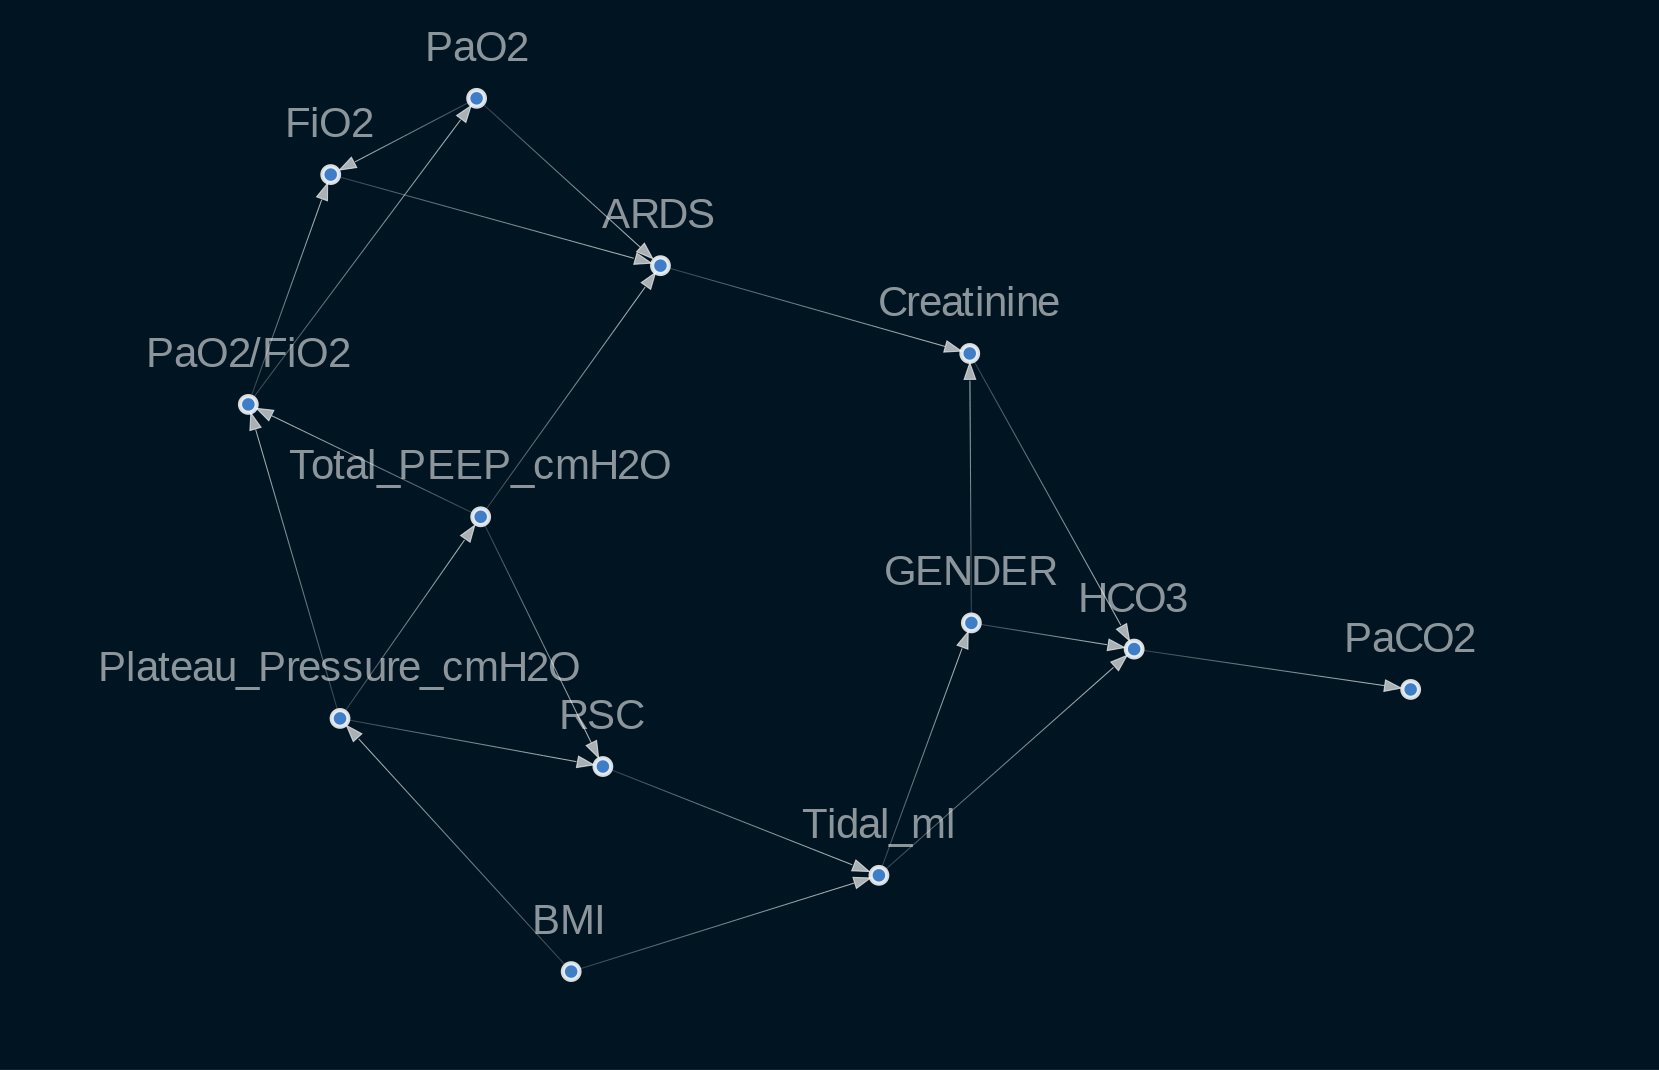

In [14]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.9"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

Having no expert knowledge to draw on, we leave the SCM in this form. We see that it is a valid DAG.

## Bayesian Network

In [0]:
from causalnex.network import BayesianNetwork
bn = BayesianNetwork(sm)

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_enc_disc, train_size=0.9,\
  test_size=0.1, random_state=7)

In [0]:
bn = bn.fit_node_states(df_enc_disc)

In [0]:
bn = bn.fit_cpds(train, method='BayesianEstimator', bayes_prior='K2')

In [40]:
bn.cpds['ARDS']

FiO2                      High FiO2  ...        Normal FiO2
PaO2                      High PaO2  ...        Normal PaO2
Total_PEEP_cmH2O Total_PEEP_cmH2O 1  ... Total_PEEP_cmH2O 5
ARDS                                 ...                   
0.0                           0.625  ...                0.5
1.0                           0.375  ...                0.5

[2 rows x 30 columns]